In [1]:
# Import key libraries
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
import collections
from torch.utils.data import Dataset
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


### Loading and preprocessing the dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1)  # Load MNIST data
X, y = mnist["data"], mnist["target"]
y = y.astype(int)  # Convert labels to integers

In [3]:
# Normalize X to have values between -1 and 1
X = ((X / 255.) - .5) * 2

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Split the training dataset into training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in split.split(X_train, y_train):
    X_train_strat = X_train.iloc[train_index]
    y_train_strat = y_train.iloc[train_index]
    X_dev_strat = X_train.iloc[val_index]
    y_dev_strat = y_train.iloc[val_index]

# Print the shapes of the resulting arrays
print(X.shape, y.shape)
print(min(y), max(y))
print(type(X), type(y))
print(X_train_strat.shape, y_train_strat.shape)
print(X_dev_strat.shape, y_dev_strat.shape)

(70000, 784) (70000,)
0 9
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(54000, 784) (54000,)
(6000, 784) (6000,)


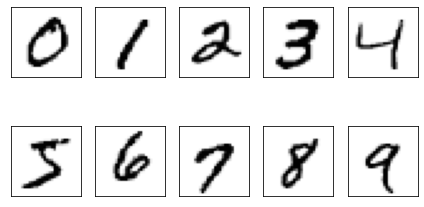

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y==i]
    ax[i].imshow(img.iloc[0].to_numpy().reshape(28, 28), cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### torch dataset

In [5]:
class MyDataset(Dataset):
    def __init__(self, input_data, labels):
        if isinstance(input_data, pd.DataFrame) or isinstance(input_data, pd.Series):
            input_data = input_data.to_numpy()
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            labels = labels.to_numpy()

        self.feats = torch.tensor(input_data, dtype=torch.float32).view(-1, 1, 28, 28)  # Reshape for CNN
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.feats[index], self.labels[index]

    
params = {'batch_size': 50, 'shuffle': True}

training_set = MyDataset(X_train_strat, y_train_strat)
dev_set      = MyDataset(X_dev_strat  , y_dev_strat)
test_set     = MyDataset(X_test       , y_test)

train_loader = DataLoader(training_set, **params)
val_loader   = DataLoader(dev_set     , **params)
test_loader  = DataLoader(test_set    , **params)

### CNN Model

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Layers
        self.conv1   = nn.Conv2d(1, 6 , kernel_size=3, stride=1)
        self.conv2   = nn.Conv2d(6, 10, kernel_size=3, stride=1)
        self.fc1     = nn.Linear(10 * 24 * 24, 10)  
        self.softmax = nn.Softmax(dim=1)

        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 10 * 24 * 24)
        x = self.fc1(x)
        #out = self.softmax(x) # Applying softmax in the forward method and then using a loss function that also applies softmax (like nn.CrossEntropyLoss) can lead to incorrect loss calculations.  
        return x

In [21]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
        elif score > self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [19]:
def train(model, device, loss_fcn, train_loader, optimizer):
    train_loss = 0
    correct = 0
    model.train(True)
    with torch.set_grad_enabled(True):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # opt initialization
            optimizer.zero_grad()
            # Model computation
            output = model(data)
            # Loss calculation
            loss = loss_fcn(output, target) # cross entropy applies softmax  
            train_loss += loss * data.size(0)
            # Backpropagation
            loss.backward()   # gradient calculation
            optimizer.step()  # weight update
            # model output
            output = model.softmax(output)
            pred = output.argmax(dim=1, keepdim=True)   
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        train_loss /= len(train_loader.dataset)
        accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy


In [9]:
def validate(model, device, loss_fcn, val_loader):
    val_loss = 0
    correct  = 0
    model.eval()
    with torch.set_grad_enabled(False):    
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            # Model computation
            output = model(data)
            # Loss calculation
            loss = loss_fcn(output, target)
            val_loss += loss * data.size(0)
            # model output
            output = model.softmax(output)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy  = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy


Epoch: 1, Training Loss: 0.1796, Validation Loss: 0.1088, Training Accuracy: 94.47%, Validation Accuracy: 96.88%
Epoch: 2, Training Loss: 0.0687, Validation Loss: 0.0868, Training Accuracy: 97.89%, Validation Accuracy: 97.93%
Epoch: 3, Training Loss: 0.0474, Validation Loss: 0.0929, Training Accuracy: 98.48%, Validation Accuracy: 97.73%
EarlyStopping counter: 1 out of 10
Epoch: 4, Training Loss: 0.0378, Validation Loss: 0.1064, Training Accuracy: 98.80%, Validation Accuracy: 97.40%
EarlyStopping counter: 2 out of 10
Epoch: 5, Training Loss: 0.0335, Validation Loss: 0.1429, Training Accuracy: 98.88%, Validation Accuracy: 96.80%
EarlyStopping counter: 3 out of 10
Epoch: 6, Training Loss: 0.0281, Validation Loss: 0.1134, Training Accuracy: 99.05%, Validation Accuracy: 97.63%
EarlyStopping counter: 4 out of 10
Epoch: 7, Training Loss: 0.0225, Validation Loss: 0.1386, Training Accuracy: 99.28%, Validation Accuracy: 97.63%
EarlyStopping counter: 5 out of 10
Epoch: 8, Training Loss: 0.0259, V

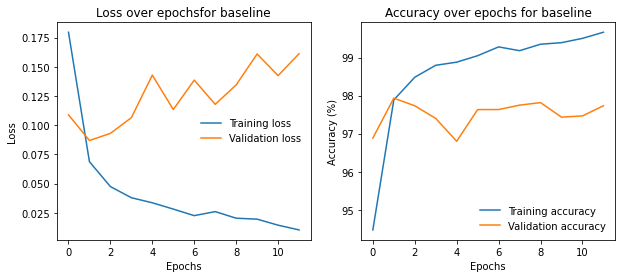

Test Accuracy: 97.72%


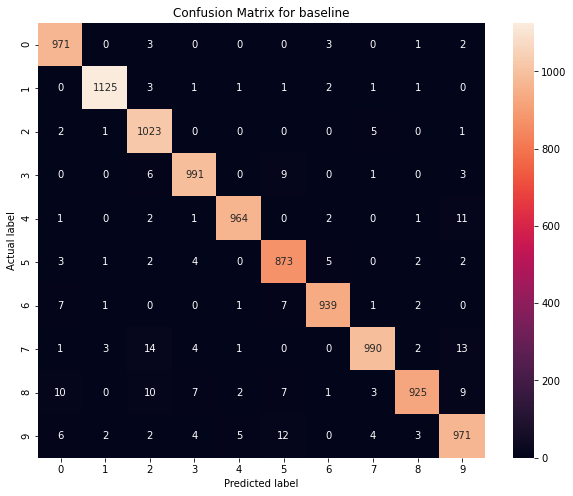

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

early_stopping = EarlyStopping(patience=10, delta=0.001)
loss = nn.CrossEntropyLoss()

train_losses     = []
val_losses       = []
train_accuracies = []
val_accuracies   = []
# Training loop
epochs = 100
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train   (model, device, loss, train_loader, optimizer)
    val_loss, val_accuracy     = validate(model, device, loss, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')
    scheduler.step()
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break    

    
plt.figure(figsize=(10, 4))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot([i.detach().numpy() for i in train_losses], label='Training loss')
plt.plot([i.detach().numpy() for i in val_losses], label='Validation loss')
plt.legend(frameon=False)
plt.title('Loss over epochsfor baseline')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Loss')  # Y-axis title

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('Accuracy over epochs for baseline')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Accuracy (%)')  # Y-axis title

plt.show()

# Test the model
test_loss, test_accuracy = validate(model, device, loss,  test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Predictions and true labels
true_labels = []
pred_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = model.softmax(output)
        pred = output.argmax(dim=1, keepdim=True).view_as(target)
        pred_labels.extend(pred.tolist())
        true_labels.extend(target.tolist())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix for baseline')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# Results 

The first set of graphs provides insight into the model's performance during training. We see that the model is learning as expected, with the training loss decreasing steadily. This means that the model is getting better at predicting the training data over time. However, the validation loss—the model's performance on new, unseen data—doesn't drop as smoothly. It goes down overall, which is good, but it does have ups and downs along the way.

When we look at accuracy, the story is similar. The model's accuracy on the training data keeps getting better, but the validation accuracy isn’t as stable. It goes up, but it bounces around more than the training accuracy. This bouncing around can be a sign that the model isn’t as reliable when it comes to data it hasn't seen before.

Despite these signs that the model might not be perfect at handling new data (a possible sign of overfitting), the test accuracy is still over 97%. This tells us that, in the end, the model is quite good at making correct predictions on data it hasn't seen, even if the learning process looked a bit rocky.